In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
from tf_keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler

from data_frame import DataFrame, MaxFiller

import matplotlib.pyplot as plt
from plotting_functions import plotTrainHistory

tfd = tfp.distributions

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

In [3]:
df = DataFrame(filePath, "QSO", filler=MaxFiller())
X_train, y_train = df.get_train_dataset()
X_val, y_val = df.get_val_dataset()

In [4]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)

2025-07-10 11:48:46.717636: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2025-07-10 11:48:46.717660: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-10 11:48:46.717665: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: borsuk
2025-07-10 11:48:46.717667: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: borsuk
2025-07-10 11:48:46.717760: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.133.7
2025-07-10 11:48:46.717779: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 5

Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 15.


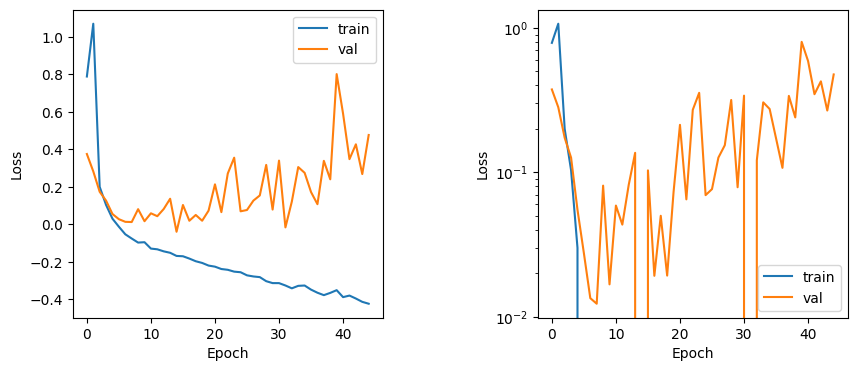

In [5]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

model = tf_keras.Sequential([Dense(256, kernel_initializer='normal', activation='relu', input_shape=(55,)),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(2),
                             tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                                                scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
                            ])

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.0001), loss=negloglik)

callback = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                            patience=30, verbose=1, 
                                            start_from_epoch=1, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128,
                    epochs=1000, verbose=0, callbacks=callback)
plotTrainHistory(history)

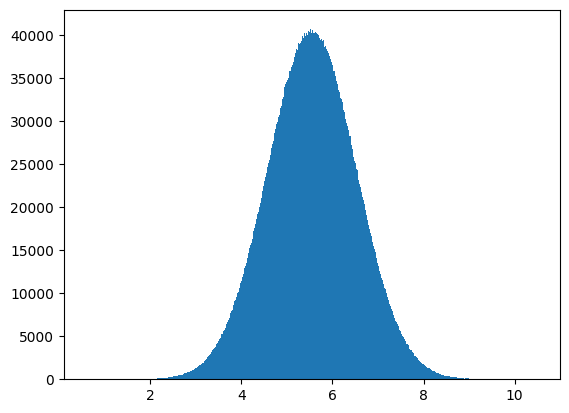

In [42]:
x = 363
y_model = model(X_val[x:x+1])
y_pred = y_model.sample(10000000).numpy()
plt.hist(y_pred.reshape(-1), bins=1000)
plt.show()

In [43]:
samples = y_model.sample(10000)
y_pred = np.median(samples)
lower = np.percentile(samples, 16)
upper = np.percentile(samples, 84)
uncertainty = (upper - lower) / 2
print(f"True value {y_val.values[x]}")
print(f"Predicted value {y_pred:.3f} +/ {uncertainty:.3f}")

True value 4.99852627687515
Predicted value 5.564 +/ 0.969


In [41]:
y_model.mean(), y_model.stddev()

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7789652]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49088955]], dtype=float32)>)

In [29]:
type(y_pred)

numpy.ndarray